In [185]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss

from importlib import reload
import deepAR
reload(deepAR)
from deepAR import GASDeepAR, NormalDistributionLoss_GAS

DeepAR = GASDeepAR


In [186]:
data = generate_ar_data(seasonality=20.0, timesteps=4000, n_series=1, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")


In [187]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,series,time_idx,value,date
0,0,0,0.000000,2020-01-01
1,0,1,0.030814,2020-01-02
2,0,2,0.073035,2020-01-03
3,0,3,0.101790,2020-01-04
4,0,4,0.119993,2020-01-05


alpha_mu:  0.9999338930386481 alpha_sigma:  0.9999338930386481 beta_mu:  0.9993386729320827 beta_sigma:  0.12217202365588586 omega_mu:  0.0009329327941828034 omega_sigma:  0.4267984451029402 nu:  99.99996300097133


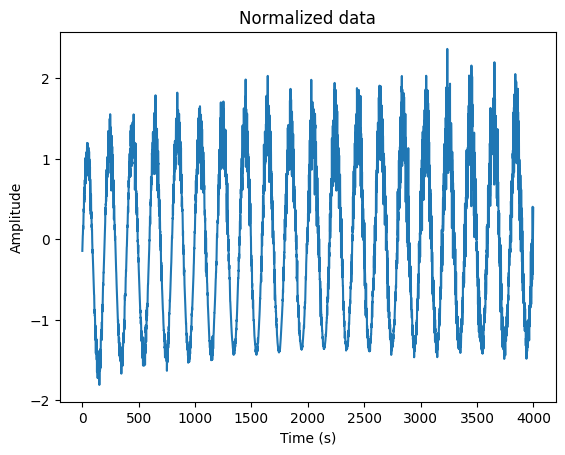

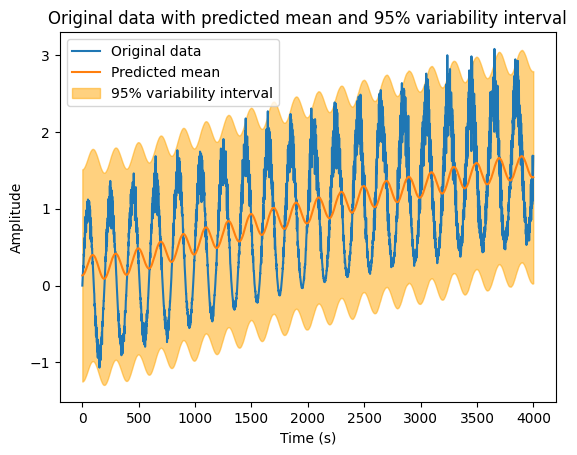

In [188]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 0.01
var_norm_strength = 0

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]


#mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(data['value'], data['value'],  mode='predict', norm_strength=norm_strength)

gas_params = alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength

#print all gas parameters in one line
print('alpha_mu: ', alpha_mu, 'alpha_sigma: ', alpha_sigma, 'beta_mu: ', beta_mu, 'beta_sigma: ', beta_sigma, 'omega_mu: ', omega_mu, 'omega_sigma: ', omega_sigma, 'nu: ', nu)


#Plot the normalized data

plt.plot(data['time_idx'][1:], y_norm[1:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

plt.plot(data['time_idx'], data['value'], label='Original data')
plt.plot(data['time_idx'], mu_list, label='Predicted mean')
plt.fill_between(data['time_idx'], mu_list-1.96*np.sqrt(sigma2_list), mu_list+1.96*np.sqrt(sigma2_list), alpha=0.5, label='95% variability interval', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original data with predicted mean and 95% variability interval')
plt.legend()







In [189]:
#Add mean and variance to the dataframe

data['mu'] = mu_list
data['sigma2'] = sigma2_list

data.head()

,series,time_idx,value,date,mu,sigma2
0,0,0,0.000000,2020-01-01,0.132114,0.496007
1,0,1,0.030814,2020-01-02,0.132451,0.496107
2,0,2,0.073035,2020-01-03,0.132998,0.496119
3,0,3,0.101790,2020-01-04,0.133687,0.496120
4,0,4,0.119993,2020-01-05,0.134462,0.496121


In [190]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=['mu', 'sigma2'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer= None,
    scalers={'mu': None, 'sigma2': None}
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [191]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss_GAS(),
    optimizer="Adam",
    gas_params= gas_params
    output_transformer = 
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
None


None


None


None


None


None


None


None


None


None


None


None


None



`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [03:07<00:00,  1.87s/it]
Learning rate set to 0.022387211385683406
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_4296c9ec-630a-4f84-b2fb-1ddd6f80d471.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_4296c9ec-630a-4f84-b2fb-1ddd6f80d471.ckpt


suggested learning rate: 0.022387211385683406


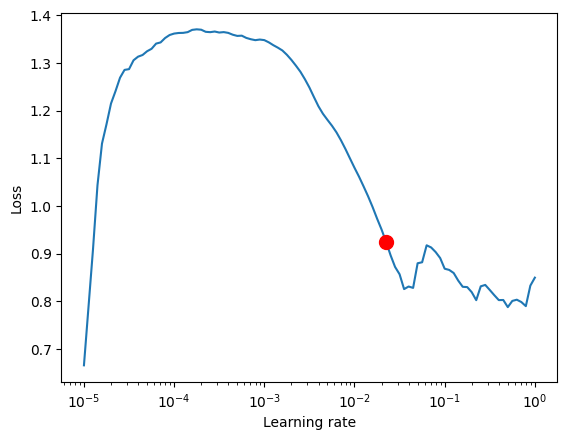

In [192]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()




In [193]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss_GAS(),
    optimizer="Adam",
    gas_params= gas_params
)

net.hparams.learning_rate = res.suggestion()

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                       | Params
----------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss_GAS | 0     
1 | logging_metrics        | ModuleList                 | 0     
2 | embeddings             | MultiEmbedding             | 1     
3 | rnn                    | LSTM                       | 11.8 K
4 | distribution_projector | Linear                     | 62    
5 | AR_GAS                 | AR_GAS                     | 0     
----------------------------------------------------------------------
11.8 K    Trainable params
0         Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 29/29 [00:54<00:00,  0.53it/s, v_num=16, train_loss_step=-.208, val_loss=-.085, train_loss_epoch=0.202]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 29/29 [00:54<00:00,  0.53it/s, v_num=16, train_loss_step=-.208, val_loss=-.085, train_loss_epoch=0.202]


In [194]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [195]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100


tensor(0.6347)

In [204]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100


In [205]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[0.5364, 0.4939, 0.4900,  ..., 0.5877, 0.4573, 0.5428],
         [0.5926, 0.4451, 0.5273,  ..., 0.5446, 0.5844, 0.5782],
         [0.6029, 0.5191, 0.4630,  ..., 0.4833, 0.4428, 0.5651],
         ...,
         [0.4021, 0.2928, 0.3325,  ..., 0.2298, 0.2488, 0.3991],
         [0.3326, 0.4269, 0.1884,  ..., 0.2974, 0.3957, 0.3021],
         [0.1908, 0.3244, 0.3329,  ..., 0.2635, 0.4045, 0.3900]]])), x={'encoder_cat': tensor([[[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
      

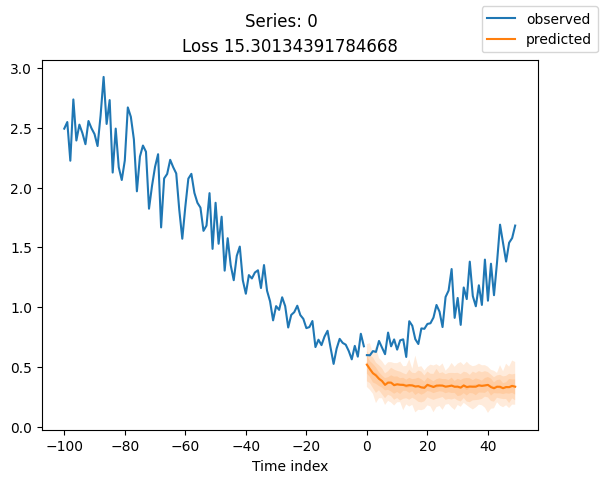

In [206]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

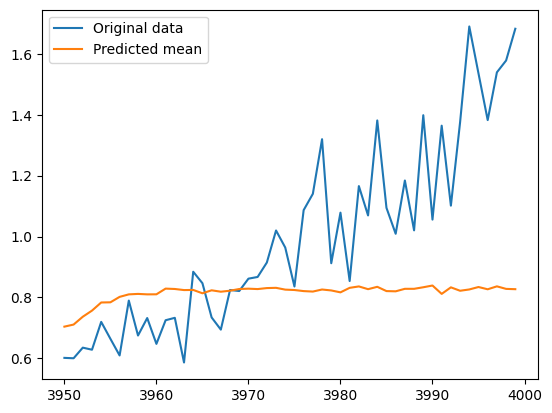

In [199]:
from Models import AR_GAS
from GAS_norm import Update_function_Student
import numpy as np

#Create the model
last_mu = data[lambda x: x.time_idx == training_cutoff]['mu']
last_sigma = data[lambda x: x.time_idx == training_cutoff]['sigma2']
k=prediction_length

def gas(last_mu, last_sigma, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength):
        mu_pred = np.zeros(k)
        sigma_pred = np.zeros(k)
        mu_pred[0], sigma_pred[0] = Update_function_Student(last_mu, last_mu, last_sigma, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
        for i in range(1, k):
            mu_pred[i], sigma_pred[i] = Update_function_Student(mu_pred[i-1], mu_pred[i-1], sigma_pred[i-1], alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
        return mu_pred, np.sqrt(sigma_pred)

mu_pred, sigma_pred = gas(last_mu, last_sigma, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)

#Change the shape of the prediction and make it a numpy array. Then plot it togheter with the last 50 values of the original data
predictions = torch.mean(raw_predictions.output[0], dim=2).detach().numpy()
predictions.shape = (k,)

plt.plot(data['time_idx'][-k:], data['value'][-k:], label='Original data')
plt.plot(data['time_idx'][-k:], (mu_pred-predictions)*sigma_pred, label='Predicted mean')
plt.legend()
plt.show()



None
tensor([[ 1.5235,  0.6981, -1.4260,  0.1347],
        [ 1.5235,  0.6974, -1.4467,  0.1342],
        [ 1.5234,  0.6973, -1.4670,  0.1333],
        [ 1.5233,  0.6973, -1.4678,  0.1331],
        [ 1.5232,  0.6973, -1.4646,  0.1331],
        [ 1.5232,  0.6973, -1.4303,  0.1344],
        [ 1.5231,  0.6973, -1.4171,  0.1353],
        [ 1.5230,  0.6973, -1.4298,  0.1351],
        [ 1.5230,  0.6973, -1.3808,  0.1371],
        [ 1.5229,  0.6973, -1.3709,  0.1380],
        [ 1.5228,  0.6973, -1.3514,  0.1392],
        [ 1.5227,  0.6973, -1.3647,  0.1391],
        [ 1.5227,  0.6973, -1.3516,  0.1396],
        [ 1.5226,  0.6973, -1.3308,  0.1407],
        [ 1.5225,  0.6973, -1.3669,  0.1395],
        [ 1.5224,  0.6973, -1.2913,  0.1425],
        [ 1.5224,  0.6973, -1.2175,  0.1465],
        [ 1.5223,  0.6973, -1.2129,  0.1481],
        [ 1.5222,  0.6973, -1.2447,  0.1474],
        [ 1.5221,  0.6973, -1.2187,  0.1485],
        [ 1.5221,  0.6973, -1.1816,  0.1505],
        [ 1.5220,  0.6973, -1

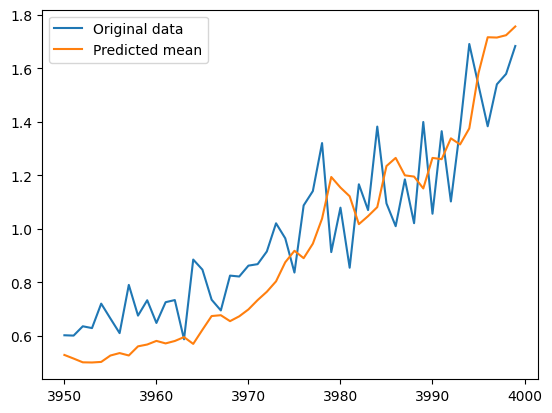

In [200]:
# Test and plot the model in training mode

for x, y in val_dataloader:
    preds = best_model(x)[0][0]

print(preds)

preds = preds[..., 2] * preds[..., 1] + preds[..., 0]
preds = preds.detach().numpy()

plt.plot(data['time_idx'][-k:], data['value'][-k:], label='Original data')
plt.plot(data['time_idx'][-k:], preds, label='Predicted mean')
plt.legend()
plt.show()